# Problem
The purpose of this notebook is to compare HOG descriptors with PCA dimension reduction and my selected features of image.


The main task is to classify grayscale images of handwritten digits (28 pixels by 28 pixels), into their 10 
categories (0 to 9). The dataset we will use is the MNIST dataset, a classic dataset in the machine learning community, which has been 
around for almost as long as the field itself and has been very intensively studied. It's a set of 60,000 training images, plus 10,000 test 
images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. You can think of "solving" MNIST 
as the "Hello World" of deep learning -- it's what you do to verify that your algorithms are working as expected. As you become a machine 
learning practitioner, you will see MNIST come up over and over again, in scientific papers, blog posts, and so on.

In [15]:
from sklearn.decomposition import PCA

In [2]:
import cv2
from mahotas.features import ellipse_axes, roundness, eccentricity
import numpy as np
import matplotlib.pyplot as plt

In [3]:
## [deskew]
SZ=28
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img
## [deskew]


In [4]:
def count_holes(img):
    (thresh, img) = cv2.threshold(img, 127, 255, 1)
    seed_pt = (25, 25)
    fill_color = 0
    mask = np.zeros_like(img)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    for th in range(60, 120):
        prev_mask = mask.copy()
        mask = cv2.threshold(img, th, 255, cv2.THRESH_BINARY)[1]
        mask = cv2.floodFill(mask, None, seed_pt, fill_color)[1]
        mask = cv2.bitwise_or(mask, prev_mask)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    n_centers = cv2.connectedComponents(mask)[0] - 1
    
    #axe_point = ellipse_axes(image)
    return n_centers

In [5]:
def showOpencvImage(image, isGray=False):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap = 'gray')
    plt.show()

In [9]:
def PCA_features(image, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(image)
    return pca.transform(image)

In [7]:
def my_features(image):
    n_holes = count_holes(image)
    axe_point = ellipse_axes(image)
    return [n_holes, axe_point[0], axe_point[1], roundness(image)]

In [8]:
def openCVHOG(im):
    winSize = (20,20)
    blockSize = (10,10)
    blockStride = (5,5)
    cellSize = (10,10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradients = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradients)
    descriptor = np.ravel(hog.compute(im))
    
    return descriptor

# Data preprocessing

Raw data

In [10]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

C:\Users\Szymon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
all_images = [train_images[i] for i in range(0,train_images.shape[0])] + [test_images[i] for i in range(0,test_images.shape[0])]

all_labels = list(train_labels) + list(test_labels)

print("Shape of all images: {}\nLen of all labels: {}".format(len(all_images), len(all_labels)))

Shape of all images: 70000
Len of all labels: 70000


Reducing training size to shorten learning time

In [12]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, train_size=0.014, random_state=42, stratify=all_labels)

print("Training size: {}\nTest size: {}".format(len(train_images), len(test_images)))
print("Class counter\nIn train data: {}\n In test data: {}".format(Counter(train_labels), Counter(test_labels)))

Training size: 980
Test size: 69020
Class counter
In train data: Counter({1: 110, 7: 102, 3: 100, 2: 98, 0: 97, 9: 97, 6: 96, 4: 96, 8: 96, 5: 88})
 In test data: Counter({1: 7767, 7: 7191, 3: 7041, 2: 6892, 9: 6861, 0: 6806, 6: 6780, 8: 6729, 4: 6728, 5: 6225})


C:\Users\Szymon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Visualising PCA features

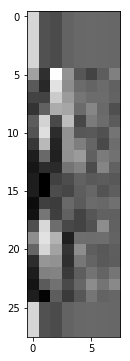

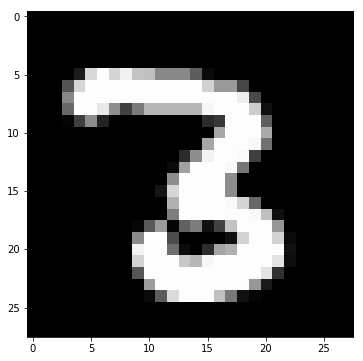

In [54]:
from sklearn.preprocessing import normalize
idx = 43
showOpencvImage(PCA_features(normalize(train_images[idx]), 8))
showOpencvImage(train_images[idx])

Vectorised raw data

In [55]:
train_raw = np.array(train_images).reshape(len(train_images), 28 * 28)
test_raw = np.array(test_images).reshape(len(test_images), 28 * 28)

Hog descriptor data

In [56]:
hogdata_train = np.float32([openCVHOG(deskew(im)) for im in train_images]).reshape(-1,81)
hogdata_test = np.float32([openCVHOG(deskew(im)) for im in test_images]).reshape(-1,81)

PCA features data

In [68]:
pca_features = 8
pca_train = np.float32([PCA_features(deskew(im), pca_features).reshape(28*8) for im in train_images])
pca_test = np.float32([PCA_features(deskew(im), pca_features).reshape(28*8) for im in test_images])

In [69]:
print("Train shape: {}\nTest shape: {}".format(pca_train.shape, pca_test.shape))

Train shape: (980, 224)
Test shape: (69020, 224)


My features: (vectors of: [holes count, parameters of the constant intensity ellipse with the same mass and second order moments as the original image, roundness])

In [70]:
my_train = [my_features(deskew(im)) for im in train_images]
my_test = [my_features(deskew(im)) for im in test_images]

# Model SVM

Model selection

In [74]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [75]:
parameters = {'kernel':('linear', 'rbf'), 'C': np.linspace(start = 0.001, stop = 2, num = 200)}

#for hog
svc_hog = SVC(class_weight='balanced')
clf = GridSearchCV(svc_hog, parameters, scoring='accuracy', cv=StratifiedKFold())
clf.fit(hogdata_train, train_labels)
params = clf.best_params_
my_svc_hog = clf.best_estimator_
print("Hog data:\nChosing params: ", params)

Hog data:
Chosing params:  {'C': 0.7041658291457287, 'kernel': 'linear'}


In [76]:
# for PCA 
svc_pca = SVC(class_weight='balanced')
clf_pca = GridSearchCV(svc_pca, parameters, scoring='accuracy', cv=StratifiedKFold())
clf_pca.fit(pca_train, train_labels)
params_pca = clf_pca.best_params_
my_svc_pca = clf_pca.best_estimator_
print("PCA data:\nChosing params: ", params_pca)

PCA data:
Chosing params:  {'C': 0.001, 'kernel': 'linear'}


In [78]:
# for my features 
svc_my = SVC(class_weight='balanced')
clf_my = GridSearchCV(svc_my, parameters, scoring='accuracy', cv=StratifiedKFold())
clf_my.fit(my_train, train_labels)
params_my = clf_my.best_params_
my_svc_my = clf_my.best_estimator_
print("My features data:\nChosing params: ", params_my)

My features data:
Chosing params:  {'C': 0.9251608040201006, 'kernel': 'rbf'}


In [79]:
# predicting with models
pred_labels_hog = my_svc_hog.predict(hogdata_test)
pred_labels_pca = my_svc_pca.predict(pca_test)
pred_labels_my = my_svc_my.predict(my_test)

In [80]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
svc_accuracy_hog = accuracy_score(test_labels, pred_labels_hog)
svc_accuracy_pca = accuracy_score(test_labels, pred_labels_pca)
svc_accuracy_my = accuracy_score(test_labels, pred_labels_my)

print("Accuracy for hog images: {}\nAccuracy for PCA images: {}\nAccuracy for my features images:{}".\
      format(svc_accuracy_hog, svc_accuracy_pca, svc_accuracy_my))

Accuracy for hog images: 0.9512170385395537
Accuracy for PCA images: 0.6444653723558389
Accuracy for my features images:0.551231527093596


In [84]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

cm_hog = confusion_matrix(test_labels, pred_labels_hog)
cm_pca = confusion_matrix(test_labels, pred_labels_pca)
cm_my = confusion_matrix(test_labels, pred_labels_my)


print("Confusion matrix for HOG images:\n{}\n\nConfusion matrix for PCA images:\n{}\n\nConfusion matrix for my features images:\n{}".\
      format(cm_hog, cm_pca, cm_my))

Confusion matrix for HOG images:
[[6598    3   14    4   38   22   44   20   10   53]
 [   2 7569   49   15   35    0   10   70    8    9]
 [  10   16 6511   29   33    8   17  151   88   29]
 [   2    4  137 6695    2   30    0   62   75   34]
 [  13    3    9    2 6478    3  102    4   48   66]
 [  19    3    8   37   34 5962   37    7   64   54]
 [  24   21    8    2   54   27 6622    0   16    6]
 [  70   10  175  175   20    3    1 6629   41   67]
 [  33   28   46   60   71  108   44   34 6132  173]
 [  55    3    5   21   41   63   11   91  114 6457]]

Confusion matrix for PCA images:
[[4783  297  217  329   63  447  417  114   85   54]
 [ 155 7322   31   38   23   48   37   20   83   10]
 [ 523   73 4289  242  245  213 1001   61  201   44]
 [ 424   95  135 4365   37 1025  179  100  547  134]
 [  68   14   78    4 4983   92  113  243   64 1069]
 [ 700  145  427 1440   71 2480  137  351  329  145]
 [ 192   96  746   79  181  316 5093   10   45   22]
 [ 343   92  150  198  308  321


*   **PRECISION** = TP / (TP+FP)
*   **RECALL** = TP + (TP+FN)
*   **F1 score** = 2*PRECISION*RECALL/(PRECISION+RECALL)
*   **ACCURACY** = SUM_OF_DIAGNONAL ELEMENTS/SUM OF ALL ELEMENTS
*   **Macro_AVG OF PRECISION** = SUM OF PRECISIONS/NUMBER OF CLASSES
*   **Weighted AVG OF PRECISION** = SUM OVER CLASSES PRECISION(CLASS)*WEIGHT*   (CLASS),
**WEIGHT** = CLASS SUPPORT/ALL ELEMENTS
*   **MICRO AVG OF PRECISION** = SUM (TP(CLASS))/SUM(TP(CLASS)+FP(CLASS))
   



# Model RandomForest

In [86]:
from sklearn.ensemble import RandomForestClassifier

Model selection

In [87]:
parameters = {'n_estimators':[i for i in range(80, 130)] , 'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

#for hog
rf_hog = RandomForestClassifier(class_weight='balanced')
clf = GridSearchCV(rf_hog, parameters, scoring='accuracy', cv=StratifiedKFold())
clf.fit(hogdata_train, train_labels)
params = clf.best_params_
my_rf_hog = clf.best_estimator_
print("Hog data:\nChosing params: ", params)

Hog data:
Chosing params:  {'max_depth': None, 'n_estimators': 127}


In [89]:
#for PCA
rf_pca = RandomForestClassifier(class_weight='balanced')
clf_pca = GridSearchCV(rf_pca, parameters, scoring='accuracy', cv=StratifiedKFold())
clf_pca.fit(pca_train, train_labels)
params_pca = clf_pca.best_params_
my_rf_pca = clf_pca.best_estimator_
print("PCA data:\nChosing params: ", params_pca)

PCA data:
Chosing params:  {'max_depth': None, 'n_estimators': 102}


In [95]:
#for my features
rf_my = RandomForestClassifier(class_weight='balanced')
clf_my = GridSearchCV(rf_my, parameters, scoring='accuracy', cv=StratifiedKFold())
clf_my.fit(my_train, train_labels)
params_my = clf_my.best_params_
my_rf_my = clf_my.best_estimator_
print("my features data:\nChosing params: ", params_my)

my features data:
Chosing params:  {'max_depth': 6, 'n_estimators': 122}


In [96]:
# predicting with models
pred_labels_hog = my_rf_hog.predict(hogdata_test)
pred_labels_pca = my_rf_pca.predict(pca_test)
pred_labels_my = my_rf_my.predict(my_test)

In [97]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
rf_accuracy_hog = accuracy_score(test_labels, pred_labels_hog)
rf_accuracy_pca = accuracy_score(test_labels, pred_labels_pca)
rf_accuracy_my = accuracy_score(test_labels, pred_labels_my)

print("Accuracy for hog images: {}\nAccuracy for PCA images: {}\nAccuracy for my features images:{}".\
      format(rf_accuracy_hog, rf_accuracy_pca, rf_accuracy_my))

Accuracy for hog images: 0.933932193567082
Accuracy for PCA images: 0.8033033903216459
Accuracy for my features images:0.5392350043465662


In [99]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

cm_hog = confusion_matrix(test_labels, pred_labels_hog)
cm_pca = confusion_matrix(test_labels, pred_labels_pca)
cm_my = confusion_matrix(test_labels, pred_labels_my)


print("Confusion matrix for HOG images:\n{}\n\nConfusion matrix for PCA images:\n{}\n\nConfusion matrix for my features images:\n{}".\
      format(cm_hog, cm_pca, cm_my))

Confusion matrix for HOG images:
[[6518    4   16    5    7  120   23   15   27   71]
 [   4 7560   44    3   39    0   13   98    3    3]
 [  14   20 6339  108   34   11   17  201  113   35]
 [   5    5  133 6634    4   49    0   99   91   21]
 [  20    7    4    1 6396   10  140    1   40  109]
 [  51   12   11   29   22 5886   54   16  105   39]
 [  77   32    3    1   59   50 6508    0   18   32]
 [ 198    6  130  170    5   32    0 6563   39   48]
 [ 108   45   38  100   87  145   45   32 5889  240]
 [ 136    7    6   21   62  102   35  110  215 6167]]

Confusion matrix for PCA images:
[[6045   66  136   92   70  144  107   20  118    8]
 [  30 7384  100   20   72   22   29    6   83   21]
 [  84   11 5582  157  152  141  565   40  146   14]
 [ 133   12  149 5698   21  433   40   84  404   67]
 [  46    5   20    2 6113   17   99   73   44  309]
 [ 108    0  606 1893   66 2809   52  379  261   51]
 [  75   13  456   64  114   54 5948    4   51    1]
 [ 161    9   91    7  199   44

# Model Neural Network

In [193]:
from keras import models
from keras import layers

#for hog
network_hog = models.Sequential()
network_hog.add(layers.Dense(512, activation='relu', input_shape=(81,)))
network_hog.add(layers.Dense(10, activation='softmax'))
#for PCA
network_pca = models.Sequential()
network_pca.add(layers.Dense(512, activation='relu', input_shape=(244,)))
network_pca.add(layers.Dense(10, activation='softmax'))
#for my features
network_my = models.Sequential()
network_my.add(layers.Dense(512, activation='relu', input_shape=(4,)))
network_my.add(layers.Dense(10, activation='softmax'))

In [194]:
network_hog.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
network_pca.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
network_my.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Data vectorisation (HOG on deskewed images and HOG on non deskewed images)

In [195]:
nn_my_train = np.array(my_train).reshape(len(my_train), 4)
nn_my_test = np.array(my_test).reshape(len(my_test), 4)
# nn_train_deskewed = np.array(hogdata_train_deskewed).reshape((len(hogdata_train_deskewed), 81))
# nn_train_deskewed = nn_train_deskewed.astype('float32') / 255

# nn_test_deskewed = np.array(hogdata_test_deskewed).reshape((len(hogdata_test_deskewed), 81))
# nn_test_deskewed = nn_test_deskewed.astype('float32') / 255

# nn_train_non_deskewed = np.array(hogdata_train).reshape((len(hogdata_train), 81))
# nn_train_non_deskewed = nn_train_non_deskewed.astype('float32') / 255

# nn_test_non_deskewed = np.array(hogdata_test).reshape((len(hogdata_test), 81))
# nn_test_non_deskewed = nn_test_non_deskewed.astype('float32') / 255

In [196]:
from keras.utils import to_categorical

encoded_train_labels = to_categorical(train_labels)
encoded_test_labels = to_categorical(test_labels)

encoded_test_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

Training our models

In [197]:
network_hog.fit(hogdata_train, encoded_train_labels, epochs=85, batch_size=128)

Epoch 1/85
980/980 [==============================] - 0s 168us/step - loss: 2.0107 - accuracy: 0.4306
Epoch 2/85
980/980 [==============================] - 0s 25us/step - loss: 1.5214 - accuracy: 0.7867
Epoch 3/85
980/980 [==============================] - 0s 23us/step - loss: 1.2346 - accuracy: 0.8041
Epoch 4/85
980/980 [==============================] - 0s 26us/step - loss: 1.0242 - accuracy: 0.8551
Epoch 5/85
980/980 [==============================] - 0s 25us/step - loss: 0.8667 - accuracy: 0.8643
Epoch 6/85
980/980 [==============================] - 0s 28us/step - loss: 0.7488 - accuracy: 0.8786
Epoch 7/85
980/980 [==============================] - 0s 29us/step - loss: 0.6483 - accuracy: 0.8898
Epoch 8/85
980/980 [==============================] - 0s 24us/step - loss: 0.5767 - accuracy: 0.8980
Epoch 9/85
980/980 [==============================] - 0s 27us/step - loss: 0.5160 - accuracy: 0.8908
Epoch 10/85
980/980 [==============================] - 0s 27us/step - loss: 0.4569 - accur

I have absolutely no idea what happened here...

In [198]:
network_pca.fit(pca_train, encoded_train_labels, epochs=300, batch_size=128)

ValueError: Error when checking input: expected dense_63_input to have shape (244,) but got array with shape (224,)

In [199]:
network_my.fit(nn_my_train, encoded_train_labels, epochs=300, batch_size=128)

Epoch 1/300
980/980 [==============================] - 0s 167us/step - loss: 2.3090 - accuracy: 0.1347
Epoch 2/300
980/980 [==============================] - 0s 26us/step - loss: 2.1456 - accuracy: 0.2684
Epoch 3/300
980/980 [==============================] - 0s 24us/step - loss: 2.0763 - accuracy: 0.3041
Epoch 4/300
980/980 [==============================] - 0s 27us/step - loss: 2.0086 - accuracy: 0.3173
Epoch 5/300
980/980 [==============================] - 0s 26us/step - loss: 1.9632 - accuracy: 0.3153
Epoch 6/300
980/980 [==============================] - 0s 22us/step - loss: 1.9263 - accuracy: 0.3541
Epoch 7/300
980/980 [==============================] - 0s 27us/step - loss: 1.8747 - accuracy: 0.3592
Epoch 8/300
980/980 [==============================] - 0s 26us/step - loss: 1.8477 - accuracy: 0.3755
Epoch 9/300
980/980 [==============================] - 0s 22us/step - loss: 1.8229 - accuracy: 0.3418
Epoch 10/300
980/980 [==============================] - 0s 22us/step - loss: 1.77

980/980 [==============================] - 0s 20us/step - loss: 1.4221 - accuracy: 0.4673
Epoch 157/300
980/980 [==============================] - 0s 21us/step - loss: 1.4355 - accuracy: 0.4612
Epoch 158/300
980/980 [==============================] - ETA: 0s - loss: 1.4743 - accuracy: 0.42 - 0s 21us/step - loss: 1.4285 - accuracy: 0.4704
Epoch 159/300
980/980 [==============================] - 0s 21us/step - loss: 1.4195 - accuracy: 0.4745
Epoch 160/300
980/980 [==============================] - 0s 19us/step - loss: 1.4269 - accuracy: 0.4704
Epoch 161/300
980/980 [==============================] - 0s 21us/step - loss: 1.4282 - accuracy: 0.4571
Epoch 162/300
980/980 [==============================] - 0s 21us/step - loss: 1.4138 - accuracy: 0.4694
Epoch 163/300
980/980 [==============================] - 0s 21us/step - loss: 1.4224 - accuracy: 0.4735
Epoch 164/300
980/980 [==============================] - 0s 21us/step - loss: 1.4144 - accuracy: 0.4765
Epoch 165/300
980/980 [=============

In [200]:
pred_probabilities_hog = network_hog.predict(hogdata_test)
#pred_probabilities_pca = network_pca.predict(pca_test)
pred_probabilities_my = network_my.predict(nn_my_test)


pred_labels_hog = np.argmax(pred_probabilities_hog,-1)
#pred_labels_pca = np.argmax(pred_probabilities_pca,-1)
pred_labels_my = np.argmax(pred_probabilities_my,-1)


In [201]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
nn_accuracy_hog = accuracy_score(test_labels, pred_labels_hog)
#nn_accuracy_pca = accuracy_score(test_labels, pred_labels_pca)
nn_accuracy_pca = None
nn_accuracy_my = accuracy_score(test_labels, pred_labels_my)

print("Accuracy for hog images: {}\nAccuracy for PCA images: {}\nAccuracy for my features images:{}".\
      format(nn_accuracy_hog, nn_accuracy_pca, nn_accuracy_my))

Accuracy for hog images: 0.9446827006664735
Accuracy for PCA images: None
Accuracy for my features images:0.48520718632280496


In [202]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

cm_hog = confusion_matrix(test_labels, pred_labels_hog)
#cm_pca = confusion_matrix(test_labels, pred_labels_pca)
cm_pca = None
cm_my = confusion_matrix(test_labels, pred_labels_my)


print("Confusion matrix for HOG images:\n{}\n\nConfusion matrix for PCA images:\n{}\n\nConfusion matrix for my features images:\n{}".\
      format(cm_hog, cm_pca, cm_my))

Confusion matrix for HOG images:
[[6531    1   21    6   52   20  117   17   25   16]
 [   4 7524   25   31   63    1   12   87    6   14]
 [   9   12 6450   71   35    7   13  143  120   32]
 [   1    3   80 6764    4   30    1   60   83   15]
 [  11    3   13   18 6480    1   85    5   69   43]
 [  17    1    6   80   39 5830   56    6  184    6]
 [  19   16    3    5   78   25 6613    0   21    0]
 [  96    2  132  149   45    5    4 6604  120   34]
 [  28   14   48   72   51   56   60   34 6301   65]
 [  93    5   24   74   77   75   25  138  245 6105]]

Confusion matrix for PCA images:
None

Confusion matrix for my features images:
[[5117    0  474  155   21  223   25   14  733   44]
 [   0 7408   10   84    3   10   29  163   47   13]
 [ 489   11 2265 2008  488  412   90  725  388   16]
 [  18   51  585 4601   66  660   40  959   59    2]
 [  88    9  901  250 3177 1434  284  376    9  200]
 [  19   12  418 3300  661 1262   22  470   34   27]
 [1072  103  998  328  272  349 1014 

In [204]:
cr_hog = classification_report(test_labels, pred_labels_hog)
#cr_pca = classification_report(test_labels, pred_labels_pca)
cr_pca = None
cr_my = classification_report(test_labels, pred_labels_my)


print("Clasification report for HOG data: \n{}\n\nClassification report for PCA data: \n{}\n\nClassification report for my features data: \n{}".\
     format(cr_hog, cr_pca, cr_my))


Clasification report for HOG data: 
             precision    recall  f1-score   support

          0       0.96      0.96      0.96      6806
          1       0.99      0.97      0.98      7767
          2       0.95      0.94      0.94      6892
          3       0.93      0.96      0.95      7041
          4       0.94      0.96      0.95      6728
          5       0.96      0.94      0.95      6225
          6       0.95      0.98      0.96      6780
          7       0.93      0.92      0.92      7191
          8       0.88      0.94      0.91      6729
          9       0.96      0.89      0.93      6861

avg / total       0.95      0.94      0.94     69020


Classification report for PCA data: 
None

Classification report for my features data: 
             precision    recall  f1-score   support

          0       0.60      0.75      0.67      6806
          1       0.93      0.95      0.94      7767
          2       0.30      0.33      0.31      6892
          3       0.34 

# Conclusion
HOG descriptors performed better than dimensionality reduction with PCA and features chosen by me. Although accuracy of PCA and my features was not as high as HOG one, it is worth to remember that it is still better than random guess, because random guess accuracy is aroung 10%.

I have no idea what happend with PCA and neural network... It probably is some bug in keras library.